# Data simulation

In [1]:
!pip install simpy

In [2]:
import simpy, random, numpy as np, pandas as pd

SIM_HOURS = 8760
env = simpy.Environment()

# Shared state
raw_inventory = 1000.0
finished_inventory = 0
energy_price = 50.0
env_temp = 25.0
env_humidity = 40.0
worker_fatigue = 1.0

# WIP buffer
lag = 3
wip_buffer = [0] * lag

# Worker pool
workers = simpy.Container(env, init=3, capacity=4)

data = []

class PowerGrid:
    def __init__(self, env):
        self.env = env
        self.voltage = 1.0
        env.process(self.fluctuate())

    def fluctuate(self):
        for _ in range(SIM_HOURS):
            yield self.env.timeout(1)
            self.voltage = max(0.5, min(1.5, self.voltage + random.gauss(0, 0.01)))
            if random.random() < 0.002:
                down = random.randint(1, 5)
                self.voltage = 0
                yield self.env.timeout(down)
                self.voltage = 1.0

class Supplier:
    def __init__(self, env):
        self.env = env
        env.process(self.deliver())

    def deliver(self):
        global raw_inventory
        for _ in range(SIM_HOURS // 24 + 20):
            yield self.env.timeout(24)
            lead = random.randint(12, 72)
            yield self.env.timeout(lead)
            raw_inventory += random.uniform(200, 800)

class Machine:
    def __init__(self, env):
        self.env = env
        self.health = 1.0
        self.working = True
        self.last_pm = 0
        self.uptime = 0
        self.failures = 0
        env.process(self.run())

    def run(self):
        global raw_inventory
        for _ in range(SIM_HOURS):
            yield self.env.timeout(1)
            if self.working:
                load = random.uniform(0.8, 1.2)
                stress = load * (30 / env_temp) * random.uniform(0.9, 1.1)
                self.health -= 0.0003 * stress
                self.uptime += 1
                if (self.env.now - self.last_pm) >= 500:
                    self.last_pm = self.env.now
                    self.health = min(1.0, self.health + 0.25)
                if random.random() < 0.0005 * (2 - self.health) or Power.voltage < 0.8:
                    self.working = False
                    self.health = 0
                    env.process(self.repair(random.random() < 0.3))
                elif random.random() < 0.0015 * (2 - self.health):
                    env.process(self.repair(False))
            if random.random() < 0.001:
                self.working = False
                down = random.randint(1, 3)
                yield self.env.timeout(down)
                self.working = True

    def repair(self, major):
        dur = random.randint(12, 24) if major else random.randint(3, 8)
        dur *= worker_fatigue
        yield workers.get(1)
        yield self.env.timeout(dur)
        self.health = min(1.0, self.health + random.uniform(0.3, 0.6))
        self.working = True
        yield workers.put(1)

# Instantiate environment components
Power = PowerGrid(env)
Supp = Supplier(env)
machines = [Machine(env) for _ in range(5)]

def simulate(env):
    global raw_inventory, finished_inventory
    global energy_price, env_temp, env_humidity, worker_fatigue
    for hour in range(SIM_HOURS):
        if raw_inventory < 200:
            raw_inventory += random.uniform(300, 600)

        energy_price += random.uniform(-1, 1)
        env_temp = 25 + 10 * np.sin(2 * np.pi * hour / 24) + random.gauss(0, 0.5)
        env_humidity = 40 + 20 * np.sin(2 * np.pi * hour / (24 * 7)) + random.gauss(0, 1)

        shift = (hour // 8) % 3
        target = 4 if shift == 1 else 2
        delta = target - workers.level
        if delta > 0:
            yield workers.put(delta)
        elif delta < 0:
            yield workers.get(-delta)

        worker_fatigue = 1 + 0.5 * (shift == 2)

        effs = [m.health if m.working else 0 for m in machines]
        availability = sum(m.working for m in machines) / len(machines)
        performance = np.mean(effs)
        quality = np.mean([0.99 if h > 0.85 else 0.92 if h > 0.6 else 0.85 for h in effs])
        oee = availability * performance * quality

        demand = random.uniform(0.85, 1.15)
        throughput = int(450 * oee * demand * Power.voltage)
        raw_inventory = max(0, raw_inventory - throughput * 0.6)

        wip_buffer.append(throughput)
        finished_inventory += wip_buffer.pop(0)

        maintenance = int(any((hour - m.last_pm) < 1 for m in machines))
        downtime = int(availability < 1)
        mtbf = np.mean([m.uptime / m.failures if m.failures > 0 else m.uptime for m in machines])

        data.append([
            hour, oee, availability, performance, quality, throughput,
            raw_inventory, sum(wip_buffer), finished_inventory,
            round(energy_price, 2), round(env_temp, 1), round(env_humidity, 1),
            round(Power.voltage, 2), workers.level, round(worker_fatigue, 2),
            maintenance, downtime, round(mtbf, 1), shift
        ])
        yield env.timeout(1)

# Start simulation
env.process(simulate(env))
env.run()

# Save data
df = pd.DataFrame(data, columns=[
    "hour", "OEE", "availability", "performance", "quality", "throughput",
    "raw_inventory", "wip", "finished", "energy_price", "temp", "humidity",
    "voltage", "available_workers", "fatigue", "maintenance", "downtime", "MTBF", "shift"
])
df.to_csv("ultra_complex_OEE.csv", index=False)

In [3]:
df.head()

,hour,OEE,availability,performance,quality,throughput,raw_inventory,wip,finished,energy_price,temp,humidity,voltage,available_workers,fatigue,maintenance,downtime,MTBF,shift
0,0,0.990000,1.0,1.000000,0.99,488,707.200000,488,0,50.67,25.9,38.6,1.00,2,1.0,1,0,0.0,0
1,1,0.989628,1.0,0.999624,0.99,506,403.600000,994,0,50.46,27.6,42.2,1.02,2,1.0,0,0,1.0,0
2,2,0.989290,1.0,0.999283,0.99,425,148.600000,1419,0,50.15,31.4,41.4,1.01,2,1.0,0,0,2.0,0
3,3,0.989012,1.0,0.999002,0.99,426,292.092631,1357,488,50.49,32.3,42.2,1.01,2,1.0,0,0,3.0,0
4,4,0.988733,1.0,0.998720,0.99,497,0.000000,1348,994,50.75,33.2,43.3,1.03,2,1.0,0,0,4.0,0


# 📊 Time Series Forecasting of OEE (Overall Equipment Effectiveness)

This notebook aims to analyze and forecast the OEE of a simulated industrial production system using time series techniques.  
We will explore the data, preprocess it, check for stationarity, and build predictive models using ARIMA-based methods.

 **Goals**:
- Visualize and understand OEE dynamics over time  
- Test for stationarity and prepare data for modeling  
- Forecast OEE using RNN/LSTM/GRU in later phases  


### Data visualisation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
df = pd.read_csv("ultra_complex_OEE.csv")
df.head()

,hour,OEE,availability,performance,quality,throughput,raw_inventory,wip,finished,energy_price,temp,humidity,voltage,available_workers,fatigue,maintenance,downtime,MTBF,shift
0,0,0.990000,1.0,1.000000,0.99,467,719.80000,467,0,50.70,25.0,41.3,1.00,2,1.0,1,0,0.0,0
1,1,0.989625,1.0,0.999621,0.99,426,464.20000,893,0,49.95,28.4,39.5,0.99,2,1.0,0,0,1.0,0
2,2,0.989318,1.0,0.999311,0.99,497,166.00000,1390,0,49.99,30.3,40.8,1.00,2,1.0,0,0,2.0,0
3,3,0.989013,1.0,0.999003,0.99,484,441.33531,1407,467,50.47,32.1,41.8,0.99,2,1.0,0,0,3.0,0
4,4,0.988750,1.0,0.998737,0.99,452,170.13531,1433,893,51.11,34.3,44.0,1.00,2,1.0,0,0,4.0,0


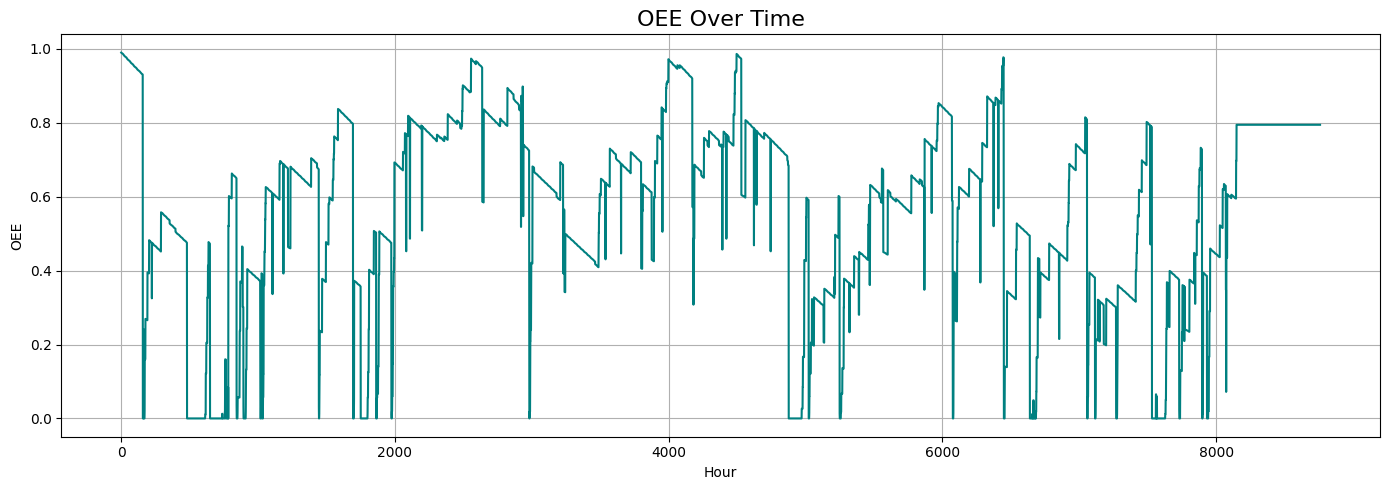

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(df["hour"], df["OEE"], color='teal')
plt.title("OEE Over Time", fontsize=16)
plt.xlabel("Hour")
plt.ylabel("OEE")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Convert hour to datetime and set as index
start_date = pd.to_datetime("2020-01-01")  # arbitrary start date
df['timestamp'] = start_date + pd.to_timedelta(df['hour'], unit='h')
df.set_index('timestamp', inplace=True)
df.drop(columns=['hour'], inplace=True)

df.head()

,OEE,availability,performance,quality,throughput,raw_inventory,wip,finished,energy_price,temp,humidity,voltage,available_workers,fatigue,maintenance,downtime,MTBF,shift
timestamp,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,0.990000,1.0,1.000000,0.99,467,719.80000,467,0,50.70,25.0,41.3,1.00,2,1.0,1,0,0.0,0
2020-01-01 01:00:00,0.989625,1.0,0.999621,0.99,426,464.20000,893,0,49.95,28.4,39.5,0.99,2,1.0,0,0,1.0,0
2020-01-01 02:00:00,0.989318,1.0,0.999311,0.99,497,166.00000,1390,0,49.99,30.3,40.8,1.00,2,1.0,0,0,2.0,0
2020-01-01 03:00:00,0.989013,1.0,0.999003,0.99,484,441.33531,1407,467,50.47,32.1,41.8,0.99,2,1.0,0,0,3.0,0
2020-01-01 04:00:00,0.988750,1.0,0.998737,0.99,452,170.13531,1433,893,51.11,34.3,44.0,1.00,2,1.0,0,0,4.0,0


In [ ]:
missing = df.isnull().sum()
missing[missing > 0]

,0


In [ ]:
plt.figure(figsize=(12,6))
df['OEE'].rolling(window=48).mean().plot(label='Rolling Mean')
df['OEE'].rolling(window=48).std().plot(label='Rolling Std')
df['OEE'].plot(alpha=0.5, label='Original')
plt.legend()
plt.title('OEE - Rolling Mean & Std (window=48 hours)')
plt.grid(True)
plt.show()

### Stationary Tests

In [ ]:
!pip install arch

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

# Significance level
alpha = 0.05

# Perform ADF test
result_adf = adfuller(df['OEE'])
print('ADF Test Results:')
print(f'  ADF Statistic: {result_adf[0]}')
print(f'  p-value: {result_adf[1]}')
print('  Critical Values:')
for key, value in result_adf[4].items():
    print(f'    {key}: {value}')
print(f"  Is Stationary (ADF): {'Yes' if result_adf[1] < alpha else 'No'}\n")

# Perform KPSS test
result_kpss = kpss(df['OEE'])
print('KPSS Test Results:')
print(f'  KPSS Statistic: {result_kpss[0]}')
print(f'  p-value: {result_kpss[1]}')
print('  Critical Values:')
for key, value in result_kpss[3].items():
    print(f'    {key}: {value}')
print(f"  Is Stationary (KPSS): {'Yes' if result_kpss[1] > alpha else 'No'}\n")

# Perform Phillips-Perron test
result_pp = PhillipsPerron(df['OEE'])
print('Phillips-Perron Test Results:')
print(f'  Phillips-Perron Statistic: {result_pp.stat}')
print(f'  p-value: {result_pp.pvalue}')
print(f'  Critical Values: {result_pp.critical_values}')
print(f"  Is Stationary (Phillips-Perron): {'Yes' if result_pp.pvalue < alpha else 'No'}")

In [ ]:
df_diff = df.diff().dropna()

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

# Significance level
alpha = 0.05

# Perform ADF test
result_adf = adfuller(df_diff['OEE'])
print('ADF Test Results:')
print(f'  ADF Statistic: {result_adf[0]}')
print(f'  p-value: {result_adf[1]}')
print('  Critical Values:')
for key, value in result_adf[4].items():
    print(f'    {key}: {value}')
print(f"  Is Stationary (ADF): {'Yes' if result_adf[1] < alpha else 'No'}\n")

# Perform KPSS test
result_kpss = kpss(df_diff['OEE'])
print('KPSS Test Results:')
print(f'  KPSS Statistic: {result_kpss[0]}')
print(f'  p-value: {result_kpss[1]}')
print('  Critical Values:')
for key, value in result_kpss[3].items():
    print(f'    {key}: {value}')
print(f"  Is Stationary (KPSS): {'Yes' if result_kpss[1] > alpha else 'No'}\n")

# Perform Phillips-Perron test
result_pp = PhillipsPerron(df_diff['OEE'])
print('Phillips-Perron Test Results:')
print(f'  Phillips-Perron Statistic: {result_pp.stat}')
print(f'  p-value: {result_pp.pvalue}')
print(f'  Critical Values: {result_pp.critical_values}')  # This line was slightly different
print(f"  Is Stationary (Phillips-Perron): {'Yes' if result_pp.pvalue < alpha else 'No'}")

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'hour' is the index of df_diff (after differencing)
plt.figure(figsize=(12, 6))
plt.plot(df_diff.index, df_diff['OEE'])
plt.title('Changes in OEE Over Time (Differenced Data)')
plt.xlabel('Time (Hours)')
plt.ylabel('Change in OEE')
plt.grid(True)
plt.show()

### ACF & PACF Test

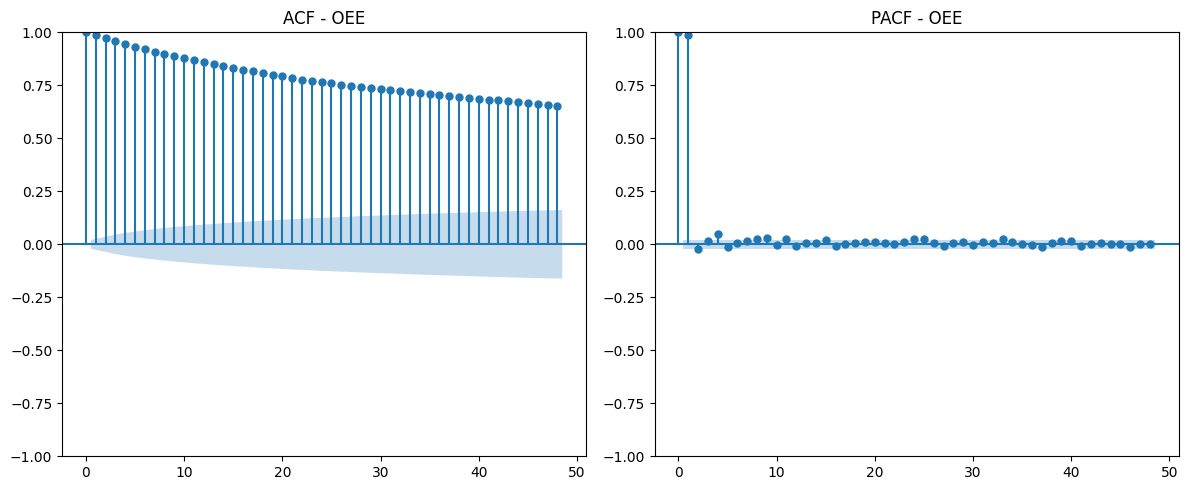

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(df['OEE'].dropna(), ax=plt.gca(), lags=48)
plt.title('ACF - OEE')

plt.subplot(1, 2, 2)
plot_pacf(df['OEE'].dropna(), ax=plt.gca(), lags=48, method='ywm')
plt.title('PACF - OEE')
plt.tight_layout()
plt.show()

### Training RNN, LSTM, and GRU models

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data = scaler.fit_transform(df['OEE'].values.reshape(-1, 1))

In [ ]:
def create_dataset(dataset, look_back=24):
  X, Y = [], []
  for i in range(len(dataset)-look_back-1):
      a = dataset[i:(i+look_back), 0]
      X.append(a)
      Y.append(dataset[i + look_back, 0])
  return np.array(X), np.array(Y)

look_back = 24 # Number of previous time steps to consider
X, Y = create_dataset(data, look_back)

train_size = int(len(X) * 0.8)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

# Reshape for LSTM/GRU/RNN input (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense

# RNN Model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
rnn_model.add(SimpleRNN(units=50))
rnn_model.add(Dense(1))
rnn_model.compile(loss='mean_squared_error', optimizer='adam')

# LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

# GRU Model
gru_model = Sequential()
gru_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
gru_model.add(GRU(units=50))
gru_model.add(Dense(1))
gru_model.compile(loss='mean_squared_error', optimizer='adam')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train the models
rnn_model.fit(X_train, Y_train, epochs=100, batch_size=32)
lstm_model.fit(X_train, Y_train, epochs=100, batch_size=32)
gru_model.fit(X_train, Y_train, epochs=100, batch_size=32)

# Make Predictions
rnn_predictions = rnn_model.predict(X_test)
lstm_predictions = lstm_model.predict(X_test)
gru_predictions = gru_model.predict(X_test)

# Invert scaling to get actual OEE values
rnn_predictions = scaler.inverse_transform(rnn_predictions)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
gru_predictions = scaler.inverse_transform(gru_predictions)

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.0538
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0026
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0024
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0019
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0022
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0023
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0019
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0022
Epoch 9/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0021
Epoch 10/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0021
Epoch 11/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0021
Epoch 12/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0017
Epoch 13/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0020
Epoch 14/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0019
Epoch 15/100
201/219 ━━━━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculer les mesures d'évaluation pour chaque modèle
rnn_rmse = np.sqrt(mean_squared_error(Y_test, rnn_predictions))
rnn_mae = mean_absolute_error(Y_test, rnn_predictions)

lstm_rmse = np.sqrt(mean_squared_error(Y_test, lstm_predictions))
lstm_mae = mean_absolute_error(Y_test, lstm_predictions)

gru_rmse = np.sqrt(mean_squared_error(Y_test, gru_predictions))
gru_mae = mean_absolute_error(Y_test, gru_predictions)

# Afficher les résultats
print('Évaluation du modèle RNN :')
print(f'  RMSE : {rnn_rmse}')
print(f'  MAE : {rnn_mae}')

print('\nÉvaluation du modèle LSTM :')
print(f'  RMSE : {lstm_rmse}')
print(f'  MAE : {lstm_mae}')

print('\nÉvaluation du modèle GRU :')
print(f'  RMSE : {gru_rmse}')
print(f'  MAE : {gru_mae}')

### Forecasting data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to generate forecasts for future time steps
def forecast_future(model, last_sequence, steps_ahead=24):
    """
    Generate forecasts for future time steps

    Parameters:
    model: Trained Keras model
    last_sequence: Last known sequence of values (lookback window)
    steps_ahead: Number of steps to forecast

    Returns:
    Array of forecasted values
    """
    current_sequence = last_sequence.copy()
    forecasts = []

    for _ in range(steps_ahead):
        # Reshape for prediction (1 sample, lookback steps, 1 feature)
        x_input = current_sequence.reshape(1, current_sequence.shape[0], 1)

        # Get prediction for next step
        next_pred = model.predict(x_input, verbose=0)[0][0]

        # Add to forecasts
        forecasts.append(next_pred)

        # Update sequence (remove oldest, add newest prediction)
        current_sequence = np.append(current_sequence[1:], next_pred)

    # Convert back to original scale
    return scaler.inverse_transform(np.array(forecasts).reshape(-1, 1))

# Get the last sequence from our data
last_known_sequence = X_test[-1]

# Generate 24-hour forecasts from each model
rnn_forecast = forecast_future(rnn_model, last_known_sequence, steps_ahead=24)
lstm_forecast = forecast_future(lstm_model, last_known_sequence, steps_ahead=24)
gru_forecast = forecast_future(gru_model, last_known_sequence, steps_ahead=24)

# Generate future time indices for plotting
last_date_idx = len(X) + look_back
future_indices = np.arange(last_date_idx, last_date_idx + 24)

# Create a figure with 3 subplots (one for each model)
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# Get actual values for historical data
actual_values = scaler.inverse_transform(data).flatten()
test_indices = range(len(actual_values) - len(Y_test), len(actual_values))
Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Plot for RNN model
axes[0].plot(range(len(actual_values)), actual_values, 'b-', label='Historical Data')
axes[0].plot(test_indices, rnn_predictions, 'g--', label='Test Predictions')
axes[0].plot(future_indices, rnn_forecast, 'g-', linewidth=2, label='Forecast')
axes[0].axvline(x=len(actual_values)-1, color='k', linestyle='--')
axes[0].set_title('RNN Model: Historical Data, Test Predictions, and Forecast')
axes[0].set_ylabel('OEE')
axes[0].legend()
axes[0].grid(True)

# Plot for LSTM model
axes[1].plot(range(len(actual_values)), actual_values, 'b-', label='Historical Data')
axes[1].plot(test_indices, lstm_predictions, 'r--', label='Test Predictions')
axes[1].plot(future_indices, lstm_forecast, 'r-', linewidth=2, label='Forecast')
axes[1].axvline(x=len(actual_values)-1, color='k', linestyle='--')
axes[1].set_title('LSTM Model: Historical Data, Test Predictions, and Forecast')
axes[1].set_ylabel('OEE')
axes[1].legend()
axes[1].grid(True)

# Plot for GRU model
axes[2].plot(range(len(actual_values)), actual_values, 'b-', label='Historical Data')
axes[2].plot(test_indices, gru_predictions, 'c--', label='Test Predictions')
axes[2].plot(future_indices, gru_forecast, 'c-', linewidth=2, label='Forecast')
axes[2].axvline(x=len(actual_values)-1, color='k', linestyle='--')
axes[2].set_title('GRU Model: Historical Data, Test Predictions, and Forecast')
axes[2].set_xlabel('Time Steps')
axes[2].set_ylabel('OEE')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Add a subplot with all models together for comparison
plt.figure(figsize=(15, 8))
plt.plot(range(len(actual_values)), actual_values, 'b-', label='Historical Data')
plt.plot(future_indices, rnn_forecast, 'g-', linewidth=2, label='RNN Forecast')
plt.plot(future_indices, lstm_forecast, 'r-', linewidth=2, label='LSTM Forecast')
plt.plot(future_indices, gru_forecast, 'c-', linewidth=2, label='GRU Forecast')
plt.axvline(x=len(actual_values)-1, color='k', linestyle='--')
plt.title('Comparison of Forecasts from All Models')
plt.xlabel('Time Steps')
plt.ylabel('OEE')
plt.legend()
plt.grid(True)
plt.show()

# Print forecast values in a table
print("\nOEE Forecasts for next 24 hours:")
print("Hour | RNN Forecast | LSTM Forecast | GRU Forecast")
print("-" * 50)
for i in range(24):
    print(f"{i+1:4d} | {rnn_forecast[i][0]:.6f} | {lstm_forecast[i][0]:.6f} | {gru_forecast[i][0]:.6f}")

# Print model evaluation metrics
print("\nModel Evaluation Metrics:")
print(f"RNN  - RMSE: {rnn_rmse:.6f}, MAE: {rnn_mae:.6f}")
print(f"LSTM - RMSE: {lstm_rmse:.6f}, MAE: {lstm_mae:.6f}")
print(f"GRU  - RMSE: {gru_rmse:.6f}, MAE: {gru_mae:.6f}")

# Streamlit

In [4]:
!pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 102.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 129.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.2 MB/s eta 0:00:00


In [5]:
!wget -q -O - ipv4.icanhzip.com

In [ ]:
%%writefile app.py
import streamlit as st

st.title("Hello from Streamlit in Colab!")
st.write("This is running inside Google Colab using pyngrok.")

In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load data
df = pd.read_csv("ultra_complex_OEE.csv")
start_date = pd.to_datetime("2020-01-01")
df['timestamp'] = start_date + pd.to_timedelta(df['hour'], unit='h')
df.set_index('timestamp', inplace=True)
df.drop(columns=['hour'], inplace=True)

# Data preprocessing
scaler = MinMaxScaler()
data = scaler.fit_transform(df['OEE'].values.reshape(-1, 1))

def create_dataset(dataset, look_back=24):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 24
X, Y = create_dataset(data, look_back)
train_size = int(len(X) * 0.8)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Model creation and training (example: LSTM)
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=0)  # verbose=0 for silent training

# Forecasting function
def forecast_future(model, last_sequence, steps_ahead=24):
    current_sequence = last_sequence.copy()
    forecasts = []
    for _ in range(steps_ahead):
        x_input = current_sequence.reshape(1, current_sequence.shape[0], 1)
        next_pred = model.predict(x_input, verbose=0)[0][0]
        forecasts.append(next_pred)
        current_sequence = np.append(current_sequence[1:], next_pred)
    return scaler.inverse_transform(np.array(forecasts).reshape(-1, 1))

# Streamlit app
st.title("Time Series OEE Forecasting")
steps_ahead = st.slider("Forecast Horizon (Hours)", min_value=1, max_value=72, value=24)

# Perform forecasting
last_known_sequence = X_test[-1]
lstm_forecast = forecast_future(lstm_model, last_known_sequence, steps_ahead=steps_ahead)

# Display results
st.header("Forecasted OEE")
st.line_chart(lstm_forecast)

In [ ]:
! streamlit run app.py & npx localtunnel --port 8501

In [ ]:
!pip install pyngrok streamlit -q
from pyngrok import ngrok

# Setup a public URL with ngrok
public_url = ngrok.connect(port='8501')
print(f"Public URL: {public_url}")

!streamlit run app.py &

# Presenting

In [6]:
%%writefile oee_dashboard.py
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import io
import base64
from datetime import datetime, timedelta

# Page configuration
st.set_page_config(
    page_title="OEE Analytics Dashboard",
    page_icon="📊",
    layout="wide",
    initial_sidebar_state="expanded",
)

# Apply dark theme with custom CSS
st.markdown("""
<style>
    .stApp {
        background-color: #1E1E1E;
        color: #FFFFFF;
    }
    .stSidebar {
        background-color: #252526;
    }
    .css-145kmo2 {
        color: #FFFFFF;
    }
    .stSelectbox label, .stSlider label {
        color: #FFFFFF;
    }
    .stMarkdown {
        color: #FFFFFF;
    }
    .custom-metric-container {
        background-color: #252526;
        border-radius: 5px;
        padding: 15px;
        margin: 10px 0;
    }
    .css-1kyxreq {
        background-color: #333333;
    }
    button {
        background-color: #0078D4;
    }
</style>
""", unsafe_allow_html=True)

# Header
st.title("🏭 OEE Analytics Dashboard")
st.markdown("### Overall Equipment Effectiveness Analysis & Forecasting")

# Load data
@st.cache_data
def load_data():
    try:
        df = pd.read_csv("ultra_complex_OEE.csv")
        # Convert hour to datetime and set as index
        start_date = pd.to_datetime("2020-01-01")  # arbitrary start date
        df['timestamp'] = start_date + pd.to_timedelta(df['hour'], unit='h')
        df.set_index('timestamp', inplace=True)
        return df
    except FileNotFoundError:
        st.error("Data file not found. Please ensure 'ultra_complex_OEE.csv' is in the correct location.")
        return None

df = load_data()

if df is not None:
    # Sidebar
    st.sidebar.title("Dashboard Controls")

    # Date range selector
    st.sidebar.subheader("Time Period Selection")
    date_range = st.sidebar.date_input(
        "Select Date Range",
        [df.index.min().date(), df.index.max().date()],
        min_value=df.index.min().date(),
        max_value=df.index.max().date()
    )

    if len(date_range) == 2:
        start_date, end_date = date_range
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date) + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)
        filtered_df = df[(df.index >= start_date) & (df.index <= end_date)]
    else:
        filtered_df = df.copy()

    # Visualization options
    st.sidebar.subheader("Visualization Options")
    chart_type = st.sidebar.selectbox(
        "Select Chart Type",
        ["Line Chart", "Area Chart", "Bar Chart", "Heatmap", "3D Scatter"]
    )

    variables = st.sidebar.multiselect(
        "Select Variables for Analysis",
        options=df.columns.tolist(),
        default=["OEE", "availability", "performance", "quality"]
    )

    # Model selection for forecasting
    st.sidebar.subheader("Forecasting Options")
    model_type = st.sidebar.selectbox(
        "Select Model Type for Forecasting",
        ["RNN", "LSTM", "GRU"]
    )

    forecast_horizon = st.sidebar.slider("Forecast Horizon (hours)", 1, 168, 24)
    lookback_window = st.sidebar.slider("Lookback Window (hours)", 1, 168, 24)

    # Main dashboard
    col1, col2, col3, col4 = st.columns(4)
    with col1:
        st.metric("Average OEE", f"{filtered_df['OEE'].mean():.2%}", f"{filtered_df['OEE'].mean() - df['OEE'].mean():.2%}")
    with col2:
        st.metric("Availability", f"{filtered_df['availability'].mean():.2%}", f"{filtered_df['availability'].mean() - df['availability'].mean():.2%}")
    with col3:
        st.metric("Performance", f"{filtered_df['performance'].mean():.2%}", f"{filtered_df['performance'].mean() - df['performance'].mean():.2%}")
    with col4:
        st.metric("Quality", f"{filtered_df['quality'].mean():.2%}", f"{filtered_df['quality'].mean() - df['quality'].mean():.2%}")

    # Time series visualization
    st.header("OEE Time Series Analysis")

    tab1, tab2, tab3, tab4 = st.tabs(["Time Series", "Correlation Analysis", "Statistical Tests", "Forecasting"])

    with tab1:
        st.subheader("Time Series Visualization")

        if chart_type == "Line Chart":
            fig = px.line(filtered_df, y=variables, title="OEE Components Over Time")
            fig.update_layout(
                template="plotly_dark",
                plot_bgcolor='rgba(30, 30, 30, 0.8)',
                paper_bgcolor='rgba(30, 30, 30, 0.8)',
                legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
            )
            st.plotly_chart(fig, use_container_width=True)

        elif chart_type == "Area Chart":
            fig = px.area(filtered_df, y=variables, title="OEE Components Over Time")
            fig.update_layout(
                template="plotly_dark",
                plot_bgcolor='rgba(30, 30, 30, 0.8)',
                paper_bgcolor='rgba(30, 30, 30, 0.8)',
                legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
            )
            st.plotly_chart(fig, use_container_width=True)

        elif chart_type == "Bar Chart":
            daily_data = filtered_df.resample('D').mean()
            fig = px.bar(daily_data, y=variables, title="Daily Average OEE Components")
            fig.update_layout(
                template="plotly_dark",
                plot_bgcolor='rgba(30, 30, 30, 0.8)',
                paper_bgcolor='rgba(30, 30, 30, 0.8)',
                legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
            )
            st.plotly_chart(fig, use_container_width=True)

        elif chart_type == "Heatmap":
            if len(variables) > 0:
                hourly_data = filtered_df[variables].groupby(filtered_df.index.hour).mean()
                daily_data = filtered_df[variables].groupby(filtered_df.index.dayofweek).mean()

                col1, col2 = st.columns(2)

                with col1:
                    fig = px.imshow(
                        hourly_data.T,
                        title="Hourly Heatmap",
                        labels=dict(x="Hour of Day", y="Metric", color="Value"),
                        x=hourly_data.index,
                        y=hourly_data.columns,
                        color_continuous_scale="Viridis"
                    )
                    fig.update_layout(template="plotly_dark")
                    st.plotly_chart(fig, use_container_width=True)

                with col2:
                    days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
                    fig = px.imshow(
                        daily_data.T,
                        title="Day of Week Heatmap",
                        labels=dict(x="Day of Week", y="Metric", color="Value"),
                        x=days,
                        y=daily_data.columns,
                        color_continuous_scale="Viridis"
                    )
                    fig.update_layout(template="plotly_dark")
                    st.plotly_chart(fig, use_container_width=True)

        elif chart_type == "3D Scatter":
            if len(variables) >= 3:
                fig = px.scatter_3d(
                    filtered_df,
                    x=variables[0],
                    y=variables[1],
                    z=variables[2],
                    color="OEE" if "OEE" in filtered_df.columns else None,
                    title="3D Relationship Between Variables"
                )
                fig.update_layout(
                    template="plotly_dark",
                    scene=dict(
                        xaxis_title=variables[0],
                        yaxis_title=variables[1],
                        zaxis_title=variables[2]
                    )
                )
                st.plotly_chart(fig, use_container_width=True)
            else:
                st.warning("Please select at least 3 variables for 3D visualization")

        # Seasonal decomposition
        if st.checkbox("Show Seasonal Decomposition"):
            target_var = st.selectbox("Select variable for decomposition", variables)

            try:
                decomposition = seasonal_decompose(filtered_df[target_var], model='additive', period=24)

                fig = make_subplots(rows=4, cols=1, shared_xaxes=True,
                                   subplot_titles=("Original", "Trend", "Seasonal", "Residual"))

                fig.add_trace(go.Scatter(x=filtered_df.index, y=filtered_df[target_var], name="Original"), row=1, col=1)
                fig.add_trace(go.Scatter(x=filtered_df.index, y=decomposition.trend, name="Trend"), row=2, col=1)
                fig.add_trace(go.Scatter(x=filtered_df.index, y=decomposition.seasonal, name="Seasonal"), row=3, col=1)
                fig.add_trace(go.Scatter(x=filtered_df.index, y=decomposition.resid, name="Residual"), row=4, col=1)

                fig.update_layout(height=800, title_text=f"Seasonal Decomposition of {target_var}", template="plotly_dark")
                st.plotly_chart(fig, use_container_width=True)

            except Exception as e:
                st.error(f"Error performing decomposition: {e}")

    with tab2:
        st.subheader("Correlation Analysis")

        corr_vars = st.multiselect(
            "Select Variables for Correlation Analysis",
            options=df.columns.tolist(),
            default=["OEE", "availability", "performance", "quality", "energy_price", "temp", "humidity"]
        )

        if corr_vars:
            corr_matrix = filtered_df[corr_vars].corr()

            fig = px.imshow(
                corr_matrix,
                text_auto=True,
                color_continuous_scale="RdBu_r",
                title="Correlation Matrix",
                zmin=-1, zmax=1
            )
            fig.update_layout(template="plotly_dark")
            st.plotly_chart(fig, use_container_width=True)

            # Scatter plot matrix
            if st.checkbox("Show Scatter Plot Matrix"):
                if len(corr_vars) <= 6:  # Limit to 6 variables to avoid overcrowding
                    fig = px.scatter_matrix(
                        filtered_df[corr_vars],
                        dimensions=corr_vars,
                        color="OEE" if "OEE" in corr_vars else None,
                        title="Scatter Plot Matrix"
                    )
                    fig.update_layout(template="plotly_dark")
                    st.plotly_chart(fig, use_container_width=True)
                else:
                    st.warning("Please select 6 or fewer variables for the scatter plot matrix")
        else:
            st.info("Please select variables for correlation analysis")

    with tab3:
        st.subheader("Statistical Tests")
        test_var = st.selectbox("Select Variable for Statistical Tests", variables)

        col1, col2 = st.columns(2)

        with col1:
            # ACF plot
            fig, ax = plt.subplots(figsize=(10, 4))
            plt.style.use('dark_background')
            plot_acf(filtered_df[test_var].dropna(), ax=ax, lags=48)
            ax.set_title(f'ACF - {test_var}', color='white')
            ax.tick_params(colors='white')
            ax.spines['bottom'].set_color('white')
            ax.spines['top'].set_color('white')
            ax.spines['left'].set_color('white')
            ax.spines['right'].set_color('white')
            ax.grid(True, linestyle='--', alpha=0.7)
            st.pyplot(fig)

        with col2:
            # PACF plot
            fig, ax = plt.subplots(figsize=(10, 4))
            plt.style.use('dark_background')
            plot_pacf(filtered_df[test_var].dropna(), ax=ax, lags=48, method='ywm')
            ax.set_title(f'PACF - {test_var}', color='white')
            ax.tick_params(colors='white')
            ax.spines['bottom'].set_color('white')
            ax.spines['top'].set_color('white')
            ax.spines['left'].set_color('white')
            ax.spines['right'].set_color('white')
            ax.grid(True, linestyle='--', alpha=0.7)
            st.pyplot(fig)

        # Stationarity Tests
        if st.checkbox("Run Stationarity Tests"):
            alpha = 0.05

            # ADF Test
            try:
                result_adf = adfuller(filtered_df[test_var].dropna())
                adf_stationary = result_adf[1] < alpha

                # KPSS Test
                result_kpss = kpss(filtered_df[test_var].dropna())
                kpss_stationary = result_kpss[1] > alpha

                # Results display
                col1, col2 = st.columns(2)

                with col1:
                    st.markdown("#### ADF Test Results")
                    st.markdown(f"**ADF Statistic:** {result_adf[0]:.4f}")
                    st.markdown(f"**p-value:** {result_adf[1]:.4f}")
                    st.markdown("**Critical Values:**")
                    for key, value in result_adf[4].items():
                        st.markdown(f"- {key}: {value:.4f}")
                    st.markdown(f"**Is Stationary:** {'✅ Yes' if adf_stationary else '❌ No'}")

                with col2:
                    st.markdown("#### KPSS Test Results")
                    st.markdown(f"**KPSS Statistic:** {result_kpss[0]:.4f}")
                    st.markdown(f"**p-value:** {result_kpss[1]:.4f}")
                    st.markdown("**Critical Values:**")
                    for key, value in result_kpss[3].items():
                        st.markdown(f"- {key}: {value:.4f}")
                    st.markdown(f"**Is Stationary:** {'✅ Yes' if kpss_stationary else '❌ No'}")

                # Differencing if needed
                if not (adf_stationary and kpss_stationary):
                    if st.checkbox("Apply Differencing"):
                        diff_df = filtered_df[test_var].diff().dropna()

                        # Test differenced series
                        diff_adf = adfuller(diff_df)
                        diff_kpss = kpss(diff_df)

                        fig = go.Figure()
                        fig.add_trace(go.Scatter(x=diff_df.index, y=diff_df, mode='lines', name='Differenced Series'))
                        fig.update_layout(
                            title=f"Differenced {test_var}",
                            template="plotly_dark"
                        )
                        st.plotly_chart(fig, use_container_width=True)

                        st.markdown("#### Stationarity Tests on Differenced Series")
                        col1, col2 = st.columns(2)
                        with col1:
                            st.markdown(f"**ADF p-value:** {diff_adf[1]:.4f} - {'✅ Stationary' if diff_adf[1] < alpha else '❌ Non-stationary'}")
                        with col2:
                            st.markdown(f"**KPSS p-value:** {diff_kpss[1]:.4f} - {'✅ Stationary' if diff_kpss[1] > alpha else '❌ Non-stationary'}")

            except Exception as e:
                st.error(f"Error running stationarity tests: {e}")

    with tab4:
        st.subheader("OEE Forecasting")

        forecast_variable = st.selectbox("Select Variable to Forecast", variables, index=variables.index("OEE") if "OEE" in variables else 0)

        # Helper function to create dataset for time series models
        @st.cache_resource
        def create_dataset(data, look_back):
            X, Y = [], []
            for i in range(len(data) - look_back - 1):
                X.append(data[i:(i+look_back)])
                Y.append(data[i + look_back])
            return np.array(X), np.array(Y)

        # Train model function
        def train_model(model_type, X_train, Y_train):
            model = Sequential()

            if model_type == "RNN":
                model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
                model.add(SimpleRNN(units=50))
            elif model_type == "LSTM":
                model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
                model.add(LSTM(units=50))
            elif model_type == "GRU":
                model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
                model.add(GRU(units=50))

            model.add(Dense(1))
            model.compile(loss='mean_squared_error', optimizer='adam')

            model.fit(X_train, Y_train, epochs=50, batch_size=32, verbose=0)
            return model

        # Forecast function
        def forecast_future(model, last_sequence, steps_ahead, scaler):
            current_sequence = last_sequence.copy()
            forecasts = []

            for _ in range(steps_ahead):
                x_input = current_sequence.reshape(1, current_sequence.shape[0], 1)
                next_pred = model.predict(x_input, verbose=0)[0][0]
                forecasts.append(next_pred)
                current_sequence = np.append(current_sequence[1:], next_pred)

            return scaler.inverse_transform(np.array(forecasts).reshape(-1, 1))

        if st.button("Generate Forecast"):
            with st.spinner(f"Training {model_type} model and generating forecast..."):
                try:
                    # Prepare data
                    data_to_forecast = filtered_df[forecast_variable].values.reshape(-1, 1)
                    scaler = MinMaxScaler()
                    scaled_data = scaler.fit_transform(data_to_forecast)

                    X, Y = create_dataset(scaled_data, lookback_window)

                    train_size = int(len(X) * 0.8)
                    X_train, X_test = X[0:train_size], X[train_size:len(X)]
                    Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

                    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
                    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

                    # Train model
                    model = train_model(model_type, X_train, Y_train)

                    # Make predictions for test data
                    test_predictions = model.predict(X_test)
                    test_predictions = scaler.inverse_transform(test_predictions)
                    Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))

                    # Generate future forecasts
                    last_sequence = scaled_data[-lookback_window:]
                    forecast = forecast_future(model, last_sequence, forecast_horizon, scaler)

                    # Create time indices for plotting
                    last_date = filtered_df.index[-1]
                    future_dates = [last_date + timedelta(hours=i+1) for i in range(forecast_horizon)]

                    # Plot results
                    fig = go.Figure()

                    # Historical data
                    fig.add_trace(go.Scatter(
                        x=filtered_df.index[-100:],
                        y=filtered_df[forecast_variable].values[-100:],
                        mode='lines',
                        name='Historical Data',
                        line=dict(color='blue')
                    ))

                    # Forecast
                    fig.add_trace(go.Scatter(
                        x=future_dates,
                        y=forecast.flatten(),
                        mode='lines',
                        name='Forecast',
                        line=dict(color='red')
                    ))

                    # Add confidence interval (simple approach)
                    error = np.std(Y_test_inv - test_predictions)
                    fig.add_trace(go.Scatter(
                        x=future_dates + future_dates[::-1],
                        y=np.concatenate([forecast.flatten() + 2*error, (forecast.flatten() - 2*error)[::-1]]),
                        fill='toself',
                        fillcolor='rgba(255,0,0,0.2)',
                        line=dict(color='rgba(255,255,255,0)'),
                        name='95% Confidence Interval'
                    ))

                    # Add vertical line at current time
                    fig.add_vline(x=last_date, line_width=2, line_dash="dash", line_color="white")
                    fig.add_annotation(x=last_date, y=max(filtered_df[forecast_variable].values[-30:]),
                                    text="Current Time", showarrow=True, arrowhead=1, ax=40)

                    fig.update_layout(
                        title=f"{forecast_horizon}-hour Forecast of {forecast_variable} using {model_type}",
                        xaxis_title="Time",
                        yaxis_title=forecast_variable,
                        template="plotly_dark",
                        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
                    )

                    st.plotly_chart(fig, use_container_width=True)

                    # Display forecast stats
                    st.markdown("### Forecast Statistics")

                    col1, col2, col3, col4 = st.columns(4)
                    with col1:
                        st.metric("Min Forecast", f"{np.min(forecast):.4f}")
                    with col2:
                        st.metric("Max Forecast", f"{np.max(forecast):.4f}")
                    with col3:
                        st.metric("Mean Forecast", f"{np.mean(forecast):.4f}")
                    with col4:
                        st.metric("Forecast Trend",
                                f"{(forecast[-1][0] - forecast[0][0]):.4f}",
                                f"{((forecast[-1][0] - forecast[0][0])/forecast[0][0]*100):.2f}%")

                    # Export forecast
                    forecast_df = pd.DataFrame({
                        'Timestamp': future_dates,
                        'Forecast': forecast.flatten(),
                        'Upper_Bound': forecast.flatten() + 2*error,
                        'Lower_Bound': forecast.flatten() - 2*error
                    })

                    csv = forecast_df.to_csv(index=False)
                    b64 = base64.b64encode(csv.encode()).decode()
                    href = f'<a href="data:file/csv;base64,{b64}" download="oee_forecast.csv">Download Forecast CSV</a>'
                    st.markdown(href, unsafe_allow_html=True)

                except Exception as e:
                    st.error(f"Error generating forecast: {e}")

    # Additional dashboard components
    st.header("OEE Breakdown Analysis")

    col1, col2 = st.columns(2)

    with col1:
        # OEE by shift
        shift_data = filtered_df.groupby('shift')['OEE'].mean().reset_index()
        fig = px.bar(
            shift_data,
            x="shift",
            y="OEE",
            title="Average OEE by Shift",
            labels={"shift": "Shift", "OEE": "Average OEE"},
            color="OEE",
            color_continuous_scale="Viridis"
        )
        fig.update_layout(template="plotly_dark")
        st.plotly_chart(fig, use_container_width=True)

    with col2:
        # Downtime analysis
        downtime_hours = filtered_df[filtered_df['downtime'] > 0].resample('D').count()['downtime']
        fig = px.line(
            x=downtime_hours.index,
            y=downtime_hours.values,
            title="Daily Downtime Events",
            labels={"x": "Date", "y": "Number of Hours with Downtime"}
        )
        fig.update_layout(template="plotly_dark")
        st.plotly_chart(fig, use_container_width=True)

    # Relationship analysis
    st.header("Factor Impact Analysis")

    col1, col2 = st.columns(2)

    with col1:
        # Temperature vs OEE
        fig = px.scatter(
            filtered_df,
            x="temp",
            y="OEE",
            title="Temperature vs OEE",
            trendline="ols",
            color="shift",
            labels={"temp": "Temperature", "OEE": "OEE Value"}
        )
        fig.update_layout(template="plotly_dark")
        st.plotly_chart(fig, use_container_width=True)

    with col2:
        # Worker fatigue vs OEE
        fig = px.scatter(
            filtered_df,
            x="fatigue",
            y="OEE",
            title="Worker Fatigue vs OEE",
            trendline="ols",
            color="shift",
            labels={"fatigue": "Worker Fatigue", "OEE": "OEE Value"}
        )
        fig.update_layout(template="plotly_dark")
        st.plotly_chart(fig, use_container_width=True)

    # Footer with information
    st.markdown("---")
    st.markdown("### About This Dashboard")
    st.markdown("""
    This interactive dashboard provides comprehensive analysis of Overall Equipment Effectiveness (OEE) data.
    It includes time series analysis, correlations, forecasting capabilities, and factor impact analysis.

    - Use the date range selector to filter data
    - Explore different visualization options
    - Generate forecasts with different models and parameters
    - Analyze the factors that impact OEE the most

    Data is refreshed automatically when the dashboard is loaded.
    """)

    # Add download links for raw data
    if st.checkbox("Show Raw Data"):
        st.dataframe(filtered_df)

        csv = filtered_df.to_csv(index=True)
        b64 = base64.b64encode(csv.encode()).decode()
        href = f'<a href="data:file/csv;base64,{b64}" download="filtered_oee_data.csv">Download Filtered Data as CSV</a>'
        st.markdown(href, unsafe_allow_html=True)
else:
    st.error("Unable to load data. Please check if the data file is available.")

Writing oee_dashboard.py


In [7]:
!streamlit run app.py

Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: app.py


In [8]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.6 MB/s eta 0:00:00


In [ ]:
!pip install pmdarima --upgrade

In [ ]:
!pip install --force-reinstall --no-cache-dir numpy
!pip install --force-reinstall --no-cache-dir pmdarima

In [ ]:
!pip install --upgrade --force-reinstall --no-binary :all: pmdarima

In [ ]:
! streamlit run oee_dashboard.py & npx localtunnel --port 8501



⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙Need to install the following packages:
localtunnel@2.0.2
Ok to proceed? (y) 
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.247.13.221:8501

y

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋your url is: https://stale-breads-wait.loca.lt
2025-04-29 08:01:26.304115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745913686.322040    1171 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745913686.328857    1171 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-29 08:01:26.351271: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary